In [80]:
import os
import math
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from IPython.core.display import display, HTML
import seaborn as sn

# import tensorflow.contrib.learn as skflow
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
# from tensorflow.python.data import Dataset

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import power_transform
from scipy.stats import boxcox
from scipy.special import inv_boxcox


from datetime import datetime

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.info('Tensorflow %s' % tf.__version__) # 1.4.1

In [81]:
def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

def clip(series, clip_to_min, clip_to_max): # TODO: Use this to clip negative fire sizes from regression model
    """
    Clips each value in the series to the given min and max values
    e.g. ([-2, 4, 1], 0, 3) -> [0, 3, 1]
    """
    return series.apply(lambda x:(
        min(max(x, clip_to_min), clip_to_max)))

def z_score_transform(series):
    """Maps each element in a series to its z-score"""
    mean = series.mean()
    std_dv = series.std()
    res = {
        "series": series.apply(lambda x:(x - mean) / std_dv),
        "params": {
            "mean": mean,
            "std_dv": std_dv
        }
    }
    return res

def inv_z_score_transform(series, mean, std_dv):
    """Maps each z-score element in a series to its original value"""
    return series.apply(lambda x: x*std_dv+mean)
    
def root_transform(series):
    """Maps each element in a series to its square root"""
    min_val = series.min()
    res = {
        "series": series.apply(lambda x: math.sqrt(1.0+x-min_val)),
        "params": {
            "min_val": min_val
        }
    }
    return res

def inv_root_transform(series, min_val):
    """Maps each element in a series to its square"""
    return series.apply(lambda x: math.pow(x, 2)-1.0+min_val),

def box_cox_transform(series):
    """Applies a Box-Cox transformation to a series"""
    min_val = series.min()
    box_cox_series, lmbda = boxcox(series.apply(lambda x: 1.0+x-min_val))
    res = {
        "series": box_cox_series,
        "params": {
            "min_val": min_val,
            "lmbda": lmbda
        }
    }
    return res
    
def inv_box_cox_transform(series, min_val, lmbda):
    """Applies an inverse Box-Cox transformation to a series with a given lambda value"""
    s = inv_boxcox(series, lmbda) #ndarray
    return pd.Series(map(lambda x: x[0]-1.0+min_val, s))
    
def linear_transform(series):
    """Applies min-max scaling to each value in the series"""
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    res = {
        "series": series.apply(lambda x: (x - min_val) / scale - 1.0),
        "params": {
            "min_val": min_val,
            "scale": scale
        }
    }
    return res

def inv_linear_transform(series, min_val, scale):
    """Undoes min-max scaling to each value in the series"""
    return series.apply(lambda x: 1.0+(x*scale+min_val))

def log_transform(series):
    """Shifts each value in the series such that the min=1 then log transforms"""
    min_val = series.min()
    res = {
        "series": series.apply(lambda x: math.log(1.0+x-min_val)),
        "params": {
            "min_val": min_val
        }
    }
    return res

def inv_log_transform(series, min_val):
    """Exponentiates log transformed values then shifts each value back"""
    return series.apply(lambda x: math.exp(x)-1.0+min_val)

def normalize(dataframe):
    """Returns a version of the input DataFrame that has all its features normalized."""
    normalized = pd.DataFrame()
    params = {}
    z_features = []
    root_features = []
    log_features = []
    linear_features = ["temperature", "humidity"]
    power_features = ["Size", "windSpeed", "windGust", "dewPoint", "windBearing", "pressure"]
    def update(res):
        normalized[column] = res["series"].astype('float32')
        params[column] = res["params"]
    for column in dataframe.columns:
        s = dataframe[column]
        if any(map(lambda k: k in column, power_features)):
            update(box_cox_transform(s))
        elif any(map(lambda k: k in column, linear_features)):
            update(linear_transform(s))
        elif any(map(lambda k: k in column, log_features)):
            update(log_transform(s))
        elif any(map(lambda k: k in column, root_features)):
            update(root_transform(s))
        elif any(map(lambda k: k in column, z_features)):
            update(z_score_transform(s))
        else:
            normalized[column] = s.astype('float32')
    return normalized, params

In [82]:
def ignition_index(indexed_feature):
    """Extracts the hour relative to fire ignition from an indexed feature.
    e.g.
    "temperature_24" -> 24
    """
    return int(indexed_feature
               .replace("summary", "")
               .replace("precipType", "")
               .replace("temperature", "")
               .replace("apparentTemperature", "")
               .replace("dewPoint", "")
               .replace("humidity", "")
               .replace("pressure", "")
               .replace("windSpeed", "")
               .replace("windGust", "")
               .replace("windBearing", "")
               .replace("cloudCover", "")
               .replace("uvIndex", "")
               .replace("visibility", "")
               .replace("precipIntensity", "")
               .replace("precipProbability", "")
               .replace("_", ""))

def indexed_feature_to_feature(indexed_feature):
    """
    Extracts the feature property name from an indexed feature name.
    e.g. "temperature_24" -> "temperature"
    """
    f = indexed_feature.replace("_", "")
    try:
        ii = str(ignition_index(indexed_feature))
        f = f.replace(ii, "")
    except:
        pass
    return f

def has_numbers(string):
    """Determines if a string has an integers"""
    return any(char.isdigit() for char in string)

In [83]:
# def construct_feature_columns(input_features):
#     """Construct the TensorFlow Feature Columns.
#     Args:
#         input_features: The names of the numerical input features to use.
#     Returns:
#         A set of feature columns
#     """ 
#     return set([tf.feature_column.numeric_column(my_feature)
#                   for my_feature in input_features.columns])

In [84]:
# def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
#     """Trains a neural network model.

#     Args:
#         features: pandas DataFrame of features
#         targets: pandas DataFrame of targets
#         batch_size: Size of batches to be passed to the model
#           shuffle: True or False. Whether to shuffle the data.
#         num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
#     Returns:
#         Tuple of (features, labels) for next data batch
#     """

#     # Convert pandas data into a dict of np arrays.
#     features = {key: np.array(value) for key, value in dict(features).items()}

#     # Construct a dataset, and configure batching/repeating.
#     ds = Dataset.from_tensor_slices((features, targets))  # warning: 2GB limit
#     ds = ds.batch(batch_size).repeat(num_epochs)

#     # Shuffle the data, if specified.
#     if shuffle:
#         ds = ds.shuffle(10)

#     # Return the next batch of data.
#     features, labels = ds.make_one_shot_iterator().get_next()
#     return features, labels

In [92]:
def preprocess_master(dataframe, features):
    """
    Prepares input features from California wildfire data.
    dataframe: A Pandas DataFrame expected to contain data
      from the training.training wildfire collection.
    Returns: A Pandas DataFrame containing the features to be used for the model.
    """
    # keep all columns that look like a desired feature and restrict only daily data
    c1 = lambda col: not has_numbers(col) # keep non time indexed features
    c2 = lambda col: (has_numbers(col) and ignition_index(col) % 24 == 0) # keep daily features
    c3 = lambda col: any(map(lambda f: f in col, features)) # if any feature is a substring of the column
    # e.g. "temperature" -> "temperature_24", "temperature0", "temperature24", ...
    cols = [col for col in dataframe.columns if not ((c1(col) or c2(col)) and c3(col))]
    dataframe = dataframe.drop(columns=cols)
    # remove all rows containing a NaN in any remaining feature
    dataframe = dataframe.dropna()
    return dataframe

def test_preprocess_master():
    dataframe = pd.DataFrame(columns=["Event", "Latitude", "Longitude", "summary0", "precipType_24", "temperature24",
                         "apparentTemperature_48", "dewPoint0", "humidity_24", "pressure48", "windSpeed48", "windGust48",
                         "windBearing0", "cloudCover_366", "uvIndex366", "visibility96", "Size", "Costs"])
    features = ["temperature", "dewPoint", "humidity", "pressure",
            "windSpeed", "windGust", "windBearing", "Size"]
    df = preprocess_master(dataframe, features)
    assert np.array_equal(df.columns, ["temperature24","dewPoint0","humidity_24","pressure48","windSpeed48","windGust48","windBearing0","Size"])
    return df

def get_split(dataframe, features):
    """
    Creates a training, validation, and test data set from the given
    Pandas DataFrame and array of feature names.
    """
    df = dataframe.copy()
    
    # use only first n-1 features as model inputs
    descriptive_features = features[:-1]
    
    # want to predict nth feature
    target_features = features[-1]

    all_targets = df[target_features]

    # create an 80/10/10 train/validation/test index split
    training_percent = .80
    training_length = math.floor(len(df.index) * training_percent)
    rest_size = len(df[training_length:].index)
    
    # construct training, validation, and test datasets
    training_df = df[0:training_length]
    validation_df = df[training_length:training_length+math.floor(rest_size/2)]
    test_df = df[training_length+math.floor(rest_size/2):]
    
    def column_split(training_df):
        features = training_df.drop(columns=target_features)
        targets = training_df[target_features]
        return features, targets
    
    
    training_features, training_targets = column_split(training_df)
    validation_features, validation_targets = column_split(validation_df)
    test_features, test_targets = column_split(test_df)
    
    return training_features,\
            training_targets,\
            validation_features,\
            validation_targets,\
            test_features,\
            test_targets, \
            all_targets

In [86]:
def feature_to_columns(df, feature):
    '''
    Returns the name of all columns in the dataframe containing the feature string.
    e.g. "temperature" -> ..., "temperature_24", "temperature0", "temperature24", ...
    '''
    return [x for x in df.columns.to_list() if feature in x]

def get_feature_bounds(df, feature):
    '''
    Returns the min and max value of a feature variable in the given dataframe.
    '''
    cols = feature_to_columns(df, feature)
    mn = min(df[cols].describe().loc["min"].to_list())
    mx = max(df[cols].describe().loc["max"].to_list())
    return mn, mx

# Load the Data

In [87]:
# Load data split from previous run

# X_train = pd.read_csv('.\\data\\'+'run_2'+'\\X_train.csv').astype("float32")
# y_train = pd.read_csv('.\\data\\'+'run_2'+'\\y_train.csv').astype("float32")
# X_valid = pd.read_csv('.\\data\\'+'run_2'+'\\X_valid.csv').astype("float32")
# y_valid = pd.read_csv('.\\data\\'+'run_2'+'\\y_valid.csv').astype("float32")
# X_test = pd.read_csv('.\\data\\'+'run_2'+'\\X_test.csv').astype("float32")
# y_test = pd.read_csv('.\\data\\'+'run_2'+'\\y_test.csv').astype("float32")

# y_all = pd.concat([y_train, y_valid, y_test])
# print(y_all.describe())

# # contains train, valid, test
# y_all.to_csv('.\\data\\'+RUN_NAME+'\\y_all.csv')

In [95]:
# load master data
csv_path = "data/wildfire_events_full.csv"
df = pd.read_csv(csv_path, low_memory=False)

# shuffle the data to prevent bias
df = df.reindex(np.random.permutation(df.index))

# # turn each time-indexed feature into just the feature name
# cols = pd.DataFrame(df.columns.to_list())
# cols.columns = ["feature"]
# cols["feature"] = cols["feature"].map(indexed_feature_to_feature)
# cols = cols.drop_duplicates().reset_index(drop=True)
# available_features = cols["feature"].to_list()
# cols

# Features available
# Event, Latitude, Longitude, summary, precipType, temperature, apparentTemperature,
# dewPoint, humidity, pressure, windSpeed, windGust, windBearing, cloudCover,
# uvIndex, visibility, Size, Costs

In [97]:
# Select the features to begin modeling, leaving the last feature as the target

# After testing I found these features to have these distributions:
# temperature: normal
# pressure: normal
# dewPoint: transform normal
# humidity: transform normal
# windSpeed: transform normal
# windGust: transform normal
# Size: transform normal
# windBearing: not transform normal
# cloudCover: not transform normal
# visibility: not transform normal
# precipIntensity: 
# precipProbability: 
# Note: cloudCover, visibility both skewed heavily due to clipping in measurement => likely not random so don't use!

features = ["temperature", "dewPoint", "humidity", "pressure",
            "windSpeed", "windGust", "Size"]

all_df = preprocess_master(df, features)
all_df.describe()

,temperature_336,dewPoint_336,humidity_336,pressure_336,windSpeed_336,windGust_336,temperature_312,dewPoint_312,humidity_312,pressure_312,windSpeed_312,windGust_312,temperature_288,dewPoint_288,humidity_288,pressure_288,windSpeed_288,windGust_288,temperature_264,dewPoint_264,humidity_264,pressure_264,windSpeed_264,windGust_264,temperature_240,dewPoint_240,humidity_240,pressure_240,windSpeed_240,windGust_240,temperature_216,dewPoint_216,humidity_216,pressure_216,windSpeed_216,windGust_216,temperature_192,dewPoint_192,humidity_192,pressure_192,windSpeed_192,windGust_192,temperature_168,dewPoint_168,humidity_168,pressure_168,windSpeed_168,windGust_168,temperature_144,dewPoint_144,humidity_144,pressure_144,windSpeed_144,windGust_144,temperature_120,dewPoint_120,humidity_120,pressure_120,windSpeed_120,windGust_120,temperature_96,dewPoint_96,humidity_96,pressure_96,windSpeed_96,windGust_96,temperature_72,dewPoint_72,humidity_72,pressure_72,windSpeed_72,windGust_72,temperature_48,dewPoint_48,humidity_48,pressure_48,windSpeed_48,windGust_48,temperature_24,dewPoint_24,humidity_24,pressure_24,windSpeed_24,windGust_24,temperature0,dewPoint0,humidity0,pressure0,windSpeed0,windGust0,temperature24,dewPoint24,humidity24,pressure24,windSpeed24,windGust24,temperature48,dewPoint48,humidity48,pressure48,windSpeed48,windGust48,temperature72,dewPoint72,humidity72,pressure72,windSpeed72,windGust72,temperature96,dewPoint96,humidity96,pressure96,windSpeed96,windGust96,temperature120,dewPoint120,humidity120,pressure120,windSpeed120,windGust120,temperature144,dewPoint144,humidity144,pressure144,windSpeed144,windGust144,temperature168,dewPoint168,humidity168,pressure168,windSpeed168,windGust168,temperature192,dewPoint192,humidity192,pressure192,windSpeed192,windGust192,temperature216,dewPoint216,humidity216,pressure216,windSpeed216,windGust216,temperature240,dewPoint240,humidity240,pressure240,windSpeed240,windGust240,temperature264,dewPoint264,humidity264,pressure264,windSpeed264,windGust264,temperature288,dewPoint288,humidity288,pressure288,windSpeed288,windGust288,temperature312,dewPoint312,humidity312,pressure312,windSpeed312,windGust312,temperature336,dewPoint336,humidity336,pressure336,windSpeed336,windGust336,Size
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,

# Exploratory Data Analysis

In [98]:
# Visualize the distribution of all descriptive features
# based on fire size quartile
display(HTML("<style>.container { width:100% !important; }</style>"))

f = "Size"
Q1 = all_df[f].describe()["25%"]
Q2 = all_df[f].describe()["50%"]
Q3 = all_df[f].describe()["75%"]
IQR = Q3-Q1
# construct dataframes with fire sizes for each quartile
q1 = all_df[all_df[f]<Q1]
q2 = all_df[all_df[f]<Q2]
q3 = all_df[all_df[f]<Q3]
# construct dataframe with no outlier fires via Tukey's method
tukey_df = all_df[(Q1-1.5*IQR <= all_df[f]) & (all_df[f] <= Q3+1.5*IQR)]
# choose the working dataframe with outlier reduced sizes
qdf = all_df
qdf.describe()

,temperature_336,dewPoint_336,humidity_336,pressure_336,windSpeed_336,windGust_336,temperature_312,dewPoint_312,humidity_312,pressure_312,windSpeed_312,windGust_312,temperature_288,dewPoint_288,humidity_288,pressure_288,windSpeed_288,windGust_288,temperature_264,dewPoint_264,humidity_264,pressure_264,windSpeed_264,windGust_264,temperature_240,dewPoint_240,humidity_240,pressure_240,windSpeed_240,windGust_240,temperature_216,dewPoint_216,humidity_216,pressure_216,windSpeed_216,windGust_216,temperature_192,dewPoint_192,humidity_192,pressure_192,windSpeed_192,windGust_192,temperature_168,dewPoint_168,humidity_168,pressure_168,windSpeed_168,windGust_168,temperature_144,dewPoint_144,humidity_144,pressure_144,windSpeed_144,windGust_144,temperature_120,dewPoint_120,humidity_120,pressure_120,windSpeed_120,windGust_120,temperature_96,dewPoint_96,humidity_96,pressure_96,windSpeed_96,windGust_96,temperature_72,dewPoint_72,humidity_72,pressure_72,windSpeed_72,windGust_72,temperature_48,dewPoint_48,humidity_48,pressure_48,windSpeed_48,windGust_48,temperature_24,dewPoint_24,humidity_24,pressure_24,windSpeed_24,windGust_24,temperature0,dewPoint0,humidity0,pressure0,windSpeed0,windGust0,temperature24,dewPoint24,humidity24,pressure24,windSpeed24,windGust24,temperature48,dewPoint48,humidity48,pressure48,windSpeed48,windGust48,temperature72,dewPoint72,humidity72,pressure72,windSpeed72,windGust72,temperature96,dewPoint96,humidity96,pressure96,windSpeed96,windGust96,temperature120,dewPoint120,humidity120,pressure120,windSpeed120,windGust120,temperature144,dewPoint144,humidity144,pressure144,windSpeed144,windGust144,temperature168,dewPoint168,humidity168,pressure168,windSpeed168,windGust168,temperature192,dewPoint192,humidity192,pressure192,windSpeed192,windGust192,temperature216,dewPoint216,humidity216,pressure216,windSpeed216,windGust216,temperature240,dewPoint240,humidity240,pressure240,windSpeed240,windGust240,temperature264,dewPoint264,humidity264,pressure264,windSpeed264,windGust264,temperature288,dewPoint288,humidity288,pressure288,windSpeed288,windGust288,temperature312,dewPoint312,humidity312,pressure312,windSpeed312,windGust312,temperature336,dewPoint336,humidity336,pressure336,windSpeed336,windGust336,Size
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,

<IPython.core.display.Javascript object>


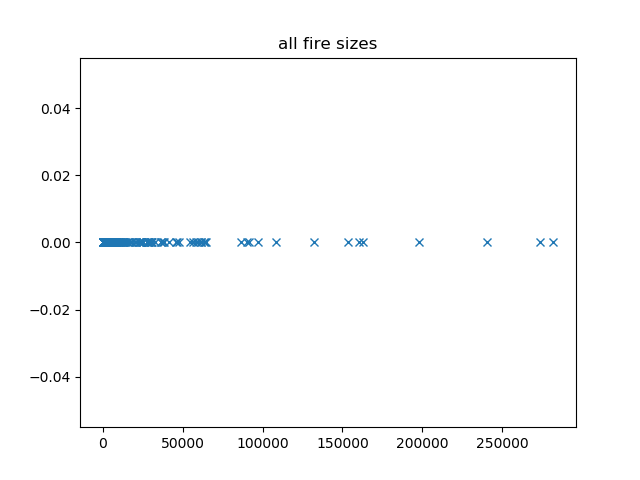

<IPython.core.display.Javascript object>


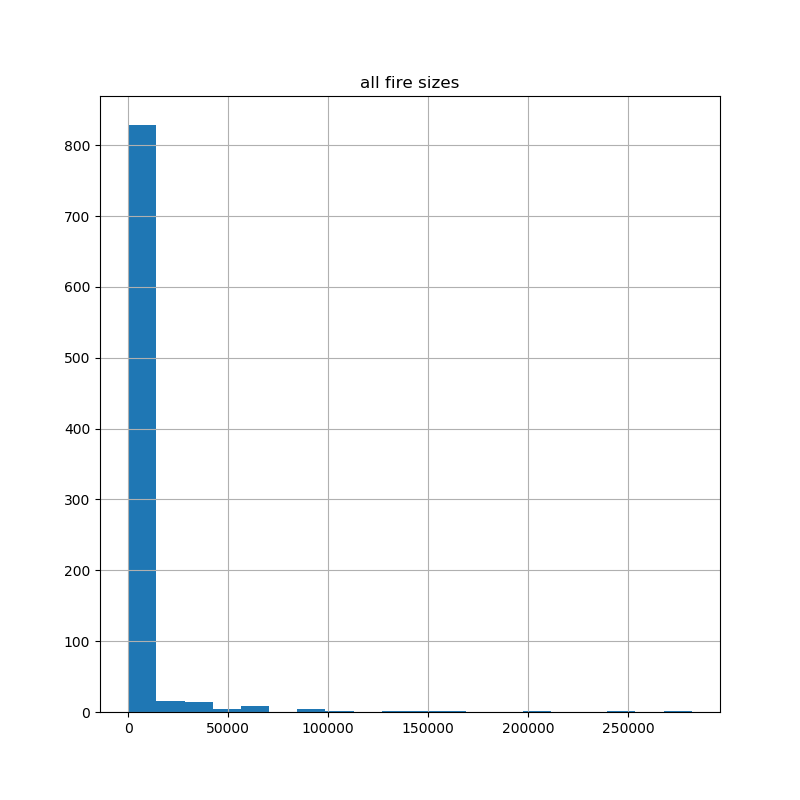

<IPython.core.display.Javascript object>


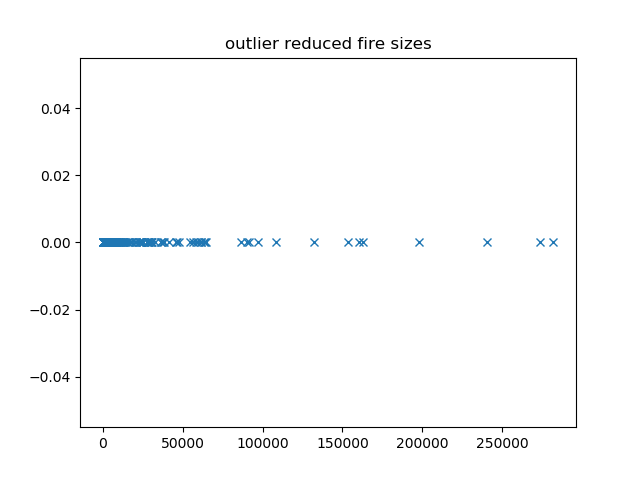

<IPython.core.display.Javascript object>


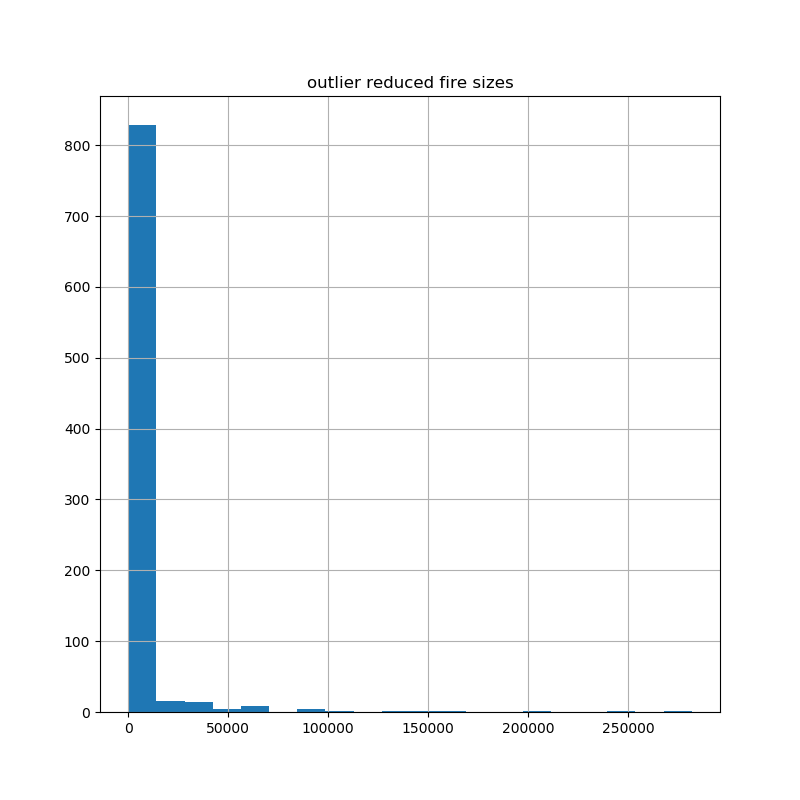

In [99]:
# Visualize the distribution of fire size in a single dimension

# plot the distribution of all fire sizes
all_sizes = all_df["Size"]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("all fire sizes")
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(all_sizes, np.zeros_like(all_sizes) + val, 'x')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("all fire sizes")
all_hist = all_df["Size"].hist(bins=20, figsize=(8, 8), xlabelsize=10)

# plot the distribution of the outlier reduced fire sizes
outlier_reduced_sizes = qdf["Size"]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("outlier reduced fire sizes")
plt.plot(outlier_reduced_sizes, np.zeros_like(outlier_reduced_sizes) + val, 'x')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("outlier reduced fire sizes")
out_red_hist = outlier_reduced_sizes.hist(bins=20, figsize=(8, 8), xlabelsize=10)



# Feature Selection

In [100]:
# Find and remove all redundant features

correlated_features = set()
correlation_matrix = qdf.drop("Size", axis=1).corr() # remove target feature
correlation_threshold = 0.8 # two features' correlation coefficient should be <

# find all pair-wise correlated descriptive features via their Pearson correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# the outlier-reduced dataframe with non pair-wise correlated descriptive features
cdf = qdf.drop(correlated_features, axis=1)

print(str(len(correlated_features))+" features removed from "+str(len(qdf.columns))+" total:")
print(sorted(list(correlated_features)))
print("\n")
print(str(len(cdf.columns))+" features remaining:")
print(sorted(cdf.columns.to_list()))

89 features removed from 175 total:
['dewPoint0', 'dewPoint120', 'dewPoint144', 'dewPoint168', 'dewPoint192', 'dewPoint216', 'dewPoint24', 'dewPoint240', 'dewPoint264', 'dewPoint288', 'dewPoint312', 'dewPoint336', 'dewPoint48', 'dewPoint72', 'dewPoint96', 'dewPoint_120', 'dewPoint_144', 'dewPoint_168', 'dewPoint_192', 'dewPoint_216', 'dewPoint_24', 'dewPoint_240', 'dewPoint_264', 'dewPoint_288', 'dewPoint_312', 'dewPoint_48', 'dewPoint_72', 'dewPoint_96', 'humidity0', 'humidity120', 'humidity144', 'humidity168', 'humidity192', 'humidity216', 'humidity240', 'humidity264', 'humidity288', 'humidity312', 'humidity336', 'humidity48', 'humidity72', 'humidity96', 'humidity_120', 'humidity_144', 'humidity_168', 'humidity_192', 'humidity_216', 'humidity_24', 'humidity_240', 'humidity_264', 'humidity_288', 'humidity_312', 'humidity_48', 'humidity_72', 'humidity_96', 'pressure288', 'pressure48', 'pressure72', 'pressure_120', 'temperature0', 'temperature120', 'temperature144', 'temperature168', 't

In [101]:
# Find top descriptive features most correlated to target
# Note: Can perform "filter" feature selection by keeping only top n descriptive features, but not done currently

# create correlation matrix of Pearson coefficients
corr_df = cdf.corr(method ="pearson")

# create heatmap of correlation matrix for all features
# fig = plt.figure(3)
# fig, ax = plt.subplots(figsize=(5,5))
# sn.heatmap(corr_df, annot=False, linewidths=.5, cmap="YlGnBu")
# plt.show()

# remove target feature row from correlation matrix
corr_df=corr_df.drop(["Size"])

# get each descriptive feature's absolute correlation strength relative to target feature
corr_df["Size"] = corr_df["Size"].map(abs)
corr_df.index.name = "feature"

# rank top absolutely correlated descriptive features relative to target feature
abs_corr_df_specific = corr_df.groupby("feature", sort=False)[["Size"]].mean().sort_values("Size",ascending=False)
abs_corr_specific_list = abs_corr_df_specific.index.to_list()
print("top features most correlated to target:")
print(len(abs_corr_specific_list))
print(abs_corr_specific_list) # Note: This is equivalent to cdf.columns.to_list() excluding target feature
print("\n")

# turn each indexed feature into just the feature name to groupby
corr_df.index = corr_df.index.map(indexed_feature_to_feature)

# rank top absolutely correlated descriptive features relative to target feature
abs_corr_df_feature = corr_df.groupby("feature", sort=False)[["Size"]].mean().sort_values("Size",ascending=False)
abs_corr_feature_list = abs_corr_df_feature.index.to_list()
print("top features most correlated to target on average:")
print(abs_corr_feature_list)
abs_corr_df_feature

top features most correlated to target:
85
['windGust72', 'humidity24', 'windGust24', 'windGust48', 'pressure336', 'pressure264', 'pressure96', 'pressure24', 'pressure192', 'windSpeed24', 'pressure240', 'pressure_96', 'pressure_72', 'pressure216', 'pressure168', 'windSpeed72', 'pressure_312', 'pressure120', 'windGust144', 'pressure_48', 'pressure_144', 'temperature_336', 'pressure_168', 'pressure_192', 'pressure_288', 'windSpeed_144', 'pressure312', 'pressure0', 'pressure144', 'windSpeed288', 'windGust312', 'pressure_240', 'pressure_336', 'windSpeed216', 'windGust96', 'windGust168', 'dewPoint_336', 'windGust_72', 'windSpeed_240', 'windSpeed48', 'windSpeed_288', 'pressure_264', 'windSpeed_192', 'pressure_24', 'windSpeed_120', 'windSpeed240', 'windSpeed_96', 'windSpeed_216', 'windSpeed_264', 'windSpeed264', 'windGust240', 'windSpeed192', 'windSpeed144', 'windGust_216', 'windSpeed_24', 'windGust_48', 'windSpeed_312', 'pressure_216', 'windSpeed_48', 'windSpeed_168', 'windSpeed312', 'windGu

,Size
feature,
humidity,0.085205
pressure,0.077952
temperature,0.071959
dewPoint,0.042464
windGust,0.036280
windSpeed,0.033746


In [102]:
# let's see the distribution of features by ignition state (pre, during, post)
pre_ignition_features = [f for f in abs_corr_specific_list if "_" in f]
ignition_features = [f for f in abs_corr_specific_list if ignition_index(f) == 0]
post_ignition_features = [f for f in abs_corr_specific_list if "_" not in f and ignition_index(f) != 0]
print("number of pre-ignition features: \n", len(pre_ignition_features))
print(pre_ignition_features)
print("\n")
print("number of ignition features: \n", len(ignition_features))
print(ignition_features)
print("\n")
print("number of post-ignition features: \n", len(post_ignition_features))
print(post_ignition_features)
print("\n")

number of pre-ignition features: 
 44
['pressure_96', 'pressure_72', 'pressure_312', 'pressure_48', 'pressure_144', 'temperature_336', 'pressure_168', 'pressure_192', 'pressure_288', 'windSpeed_144', 'pressure_240', 'pressure_336', 'dewPoint_336', 'windGust_72', 'windSpeed_240', 'windSpeed_288', 'pressure_264', 'windSpeed_192', 'pressure_24', 'windSpeed_120', 'windSpeed_96', 'windSpeed_216', 'windSpeed_264', 'windGust_216', 'windSpeed_24', 'windGust_48', 'windSpeed_312', 'pressure_216', 'windSpeed_48', 'windSpeed_168', 'windGust_264', 'humidity_336', 'windGust_336', 'windGust_96', 'windGust_192', 'windSpeed_336', 'windGust_168', 'windGust_288', 'windGust_120', 'windGust_24', 'windSpeed_72', 'windGust_240', 'windGust_144', 'windGust_312']


number of ignition features: 
 2
['pressure0', 'windSpeed0']


number of post-ignition features: 
 39
['windGust72', 'humidity24', 'windGust24', 'windGust48', 'pressure336', 'pressure264', 'pressure96', 'pressure24', 'pressure192', 'windSpeed24', 'pr

<IPython.core.display.Javascript object>


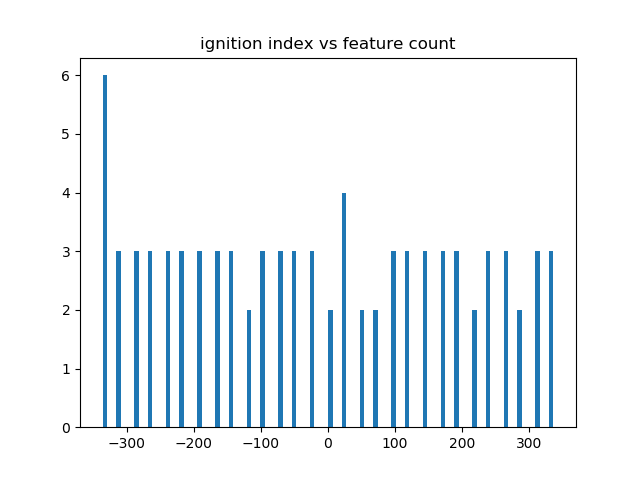

In [103]:
# let's visualize the distribution of ignition indexes for each absolutely correlated descriptive feature
g = lambda x, f: -x if "_" in f else x # convert to negative for pre-ignition features
ignition_indexes = [g(ignition_index(f), f) for f in abs_corr_specific_list]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("ignition index vs feature count")
ignition_indexes_hist = plt.hist(x=ignition_indexes, bins=100)

<IPython.core.display.Javascript object>


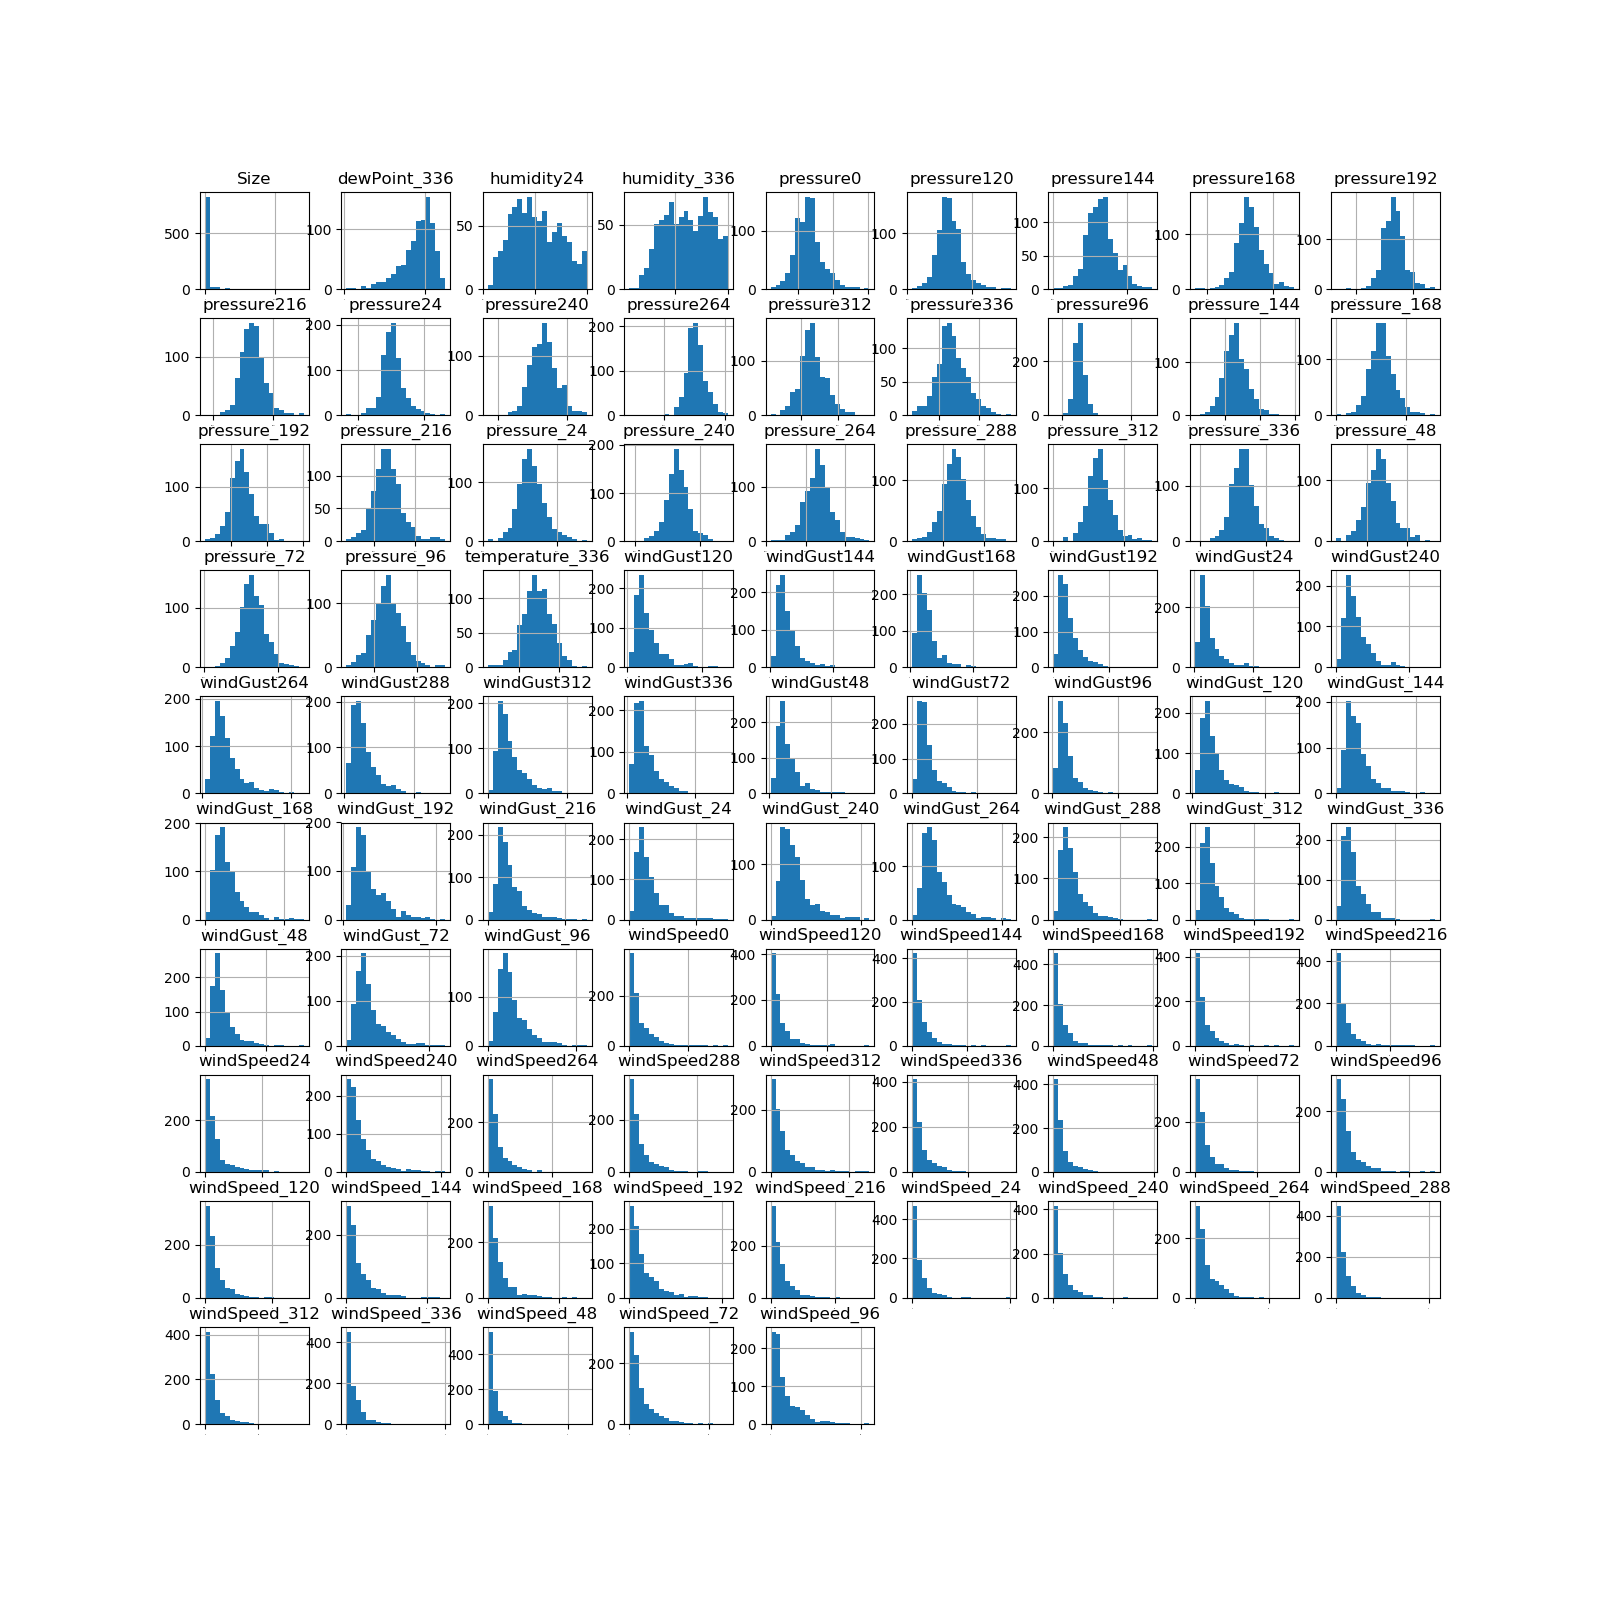

In [104]:
# View distribution of all descriptive features after outlier and correlation filtering
cdf_hist = cdf[abs_corr_specific_list+["Size"]].hist(bins=20, figsize=(16, 16), xlabelsize=1)

<IPython.core.display.Javascript object>


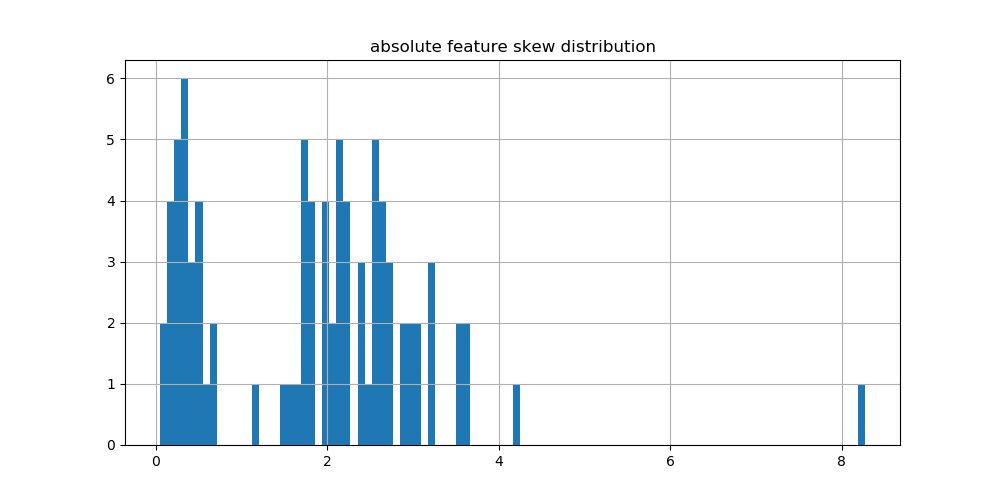

In [105]:
# Looks like some features are a bit skewed, let's see their distribution (want cluster close to 0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("absolute feature skew distribution")
skew_df = pd.DataFrame(cdf.skew())
skew_df.index.name="feature"
skew_df.columns=["skew"]
skew_df["skew"] = skew_df["skew"].map(abs)
skew_hist = skew_df["skew"].hist(bins=100, figsize=(10, 5), xlabelsize=10)

In [106]:
# let's rank each feature type by its mean absolute skew
skew_df.index = skew_df.index.map(indexed_feature_to_feature)
skew_df = skew_df.groupby("feature", sort=False)[["skew"]].mean().sort_values("skew",ascending=False)
skew_df

,skew
feature,
Size,8.271004
windSpeed,2.854831
windGust,2.001872
dewPoint,1.141494
pressure,0.456542
humidity,0.144651
temperature,0.098523


## Feature Normalization

In [107]:
# Let's normalize the outlier reduced feature filtered dataframe
ndf, params = normalize(cdf)
ndf.head(10)

,temperature_336,dewPoint_336,humidity_336,pressure_336,windSpeed_336,windGust_336,pressure_312,windSpeed_312,windGust_312,pressure_288,windSpeed_288,windGust_288,pressure_264,windSpeed_264,windGust_264,pressure_240,windSpeed_240,windGust_240,pressure_216,windSpeed_216,windGust_216,pressure_192,windSpeed_192,windGust_192,pressure_168,windSpeed_168,windGust_168,pressure_144,windSpeed_144,windGust_144,windSpeed_120,windGust_120,pressure_96,windSpeed_96,windGust_96,pressure_72,windSpeed_72,windGust_72,pressure_48,windSpeed_48,windGust_48,pressure_24,windSpeed_24,windGust_24,pressure0,windSpeed0,humidity24,pressure24,windSpeed24,windGust24,windSpeed48,windGust48,windSpeed72,windGust72,pressure96,windSpeed96,windGust96,pressure120,windSpeed120,windGust120,pressure144,windSpeed144,windGust144,pressure168,windSpeed168,windGust168,pressure192,windSpeed192,windGust192,pressure216,windSpeed216,pressure240,windSpeed240,windGust240,pressure264,windSpeed264,windGust264,windSpeed288,windGust288,pressure312,windSpeed312,windGust312,pressure336,windSpeed336,windGust336,Size
645,-0.041647,3574.299805,-0.127660,7.672649,0.717190,1.819356,4.084489,0.661081,1.533761,2.264940,0.738254,1.662855,0.716995,0.526615,1.465278,4.674052,0.561292,1.695821,3.742727,0.806929,1.831889,3.239204,0.463959,1.579363,6.364965,0.679022,1.782974,3.805110,0.833473,1.776116,0.914123,1.916249,1.955879,0.806880,2.079108,5.659680,0.881971,1.447946,5.337403,0.293056,1.488110,4.940679,0.510757,1.390408,3.607938,0.551392,-0.663158,9.049120,0.299420,1.396302,0.639906,1.699459,0.766385,1.466577,5.111508,0.697273,1.449367,3.387045,0.753614,1.372069,3.870867,0.772079,1.520549,9.272153,0.463420,1.360856,14.499221,0.815252,1.434067,6.197240,0.541355,7.921846,0.599906,1.713589,42.073101,0.693150,1.537868,0.664880,1.448653,4.186083,0.642524,1.449156,2.659111,0.574342,1.558257,6.295920
803,-0.618588,2610.867432,0.489362,11.099131,1.044726,2.897571,9.370628,0.635805,1.778075,10.259719,0.710459,1.590428,12.977681,0.523261,1.353891,11.776882,0.663475,1.580402,6.204667,0.560417,1.592282,7.863421,0.547432,1.789101,10.240376,0.616724,1.920775,7.969058,0.906694,1.985357,0.959085,2.259379,6.917590,0.613867,1.647726,9.694180,0.877283,1.880763,7.240977,0.872908,1.786284,7.703976,0.819421,1.726217,6.915693,0.947445,-0.515789,12.657547,0.931048,1.938548,1.081308,2.405507,0.861142,2.022577,6.203910,0.723433,1.900274,5.982411,0.571847,1.119965,6.499406,0.603611,1.542542,13.052905,0.736579,1.554844,20.006689,0.632590,1.572066,8.849126,0.744179,11.253675,0.672740,1.850395,64.804703,0.721642,1.743728,0.755257,1.975990,6.162165,0.869055,1.785477,5.088601,0.705175,1.740784,6.047731
206,-0.019778,7831.049805,0.574468,12.705016,0.117208,1.496195,7.932352,0.434963,1.600698,7.478351,0.821321,1.679802,11.941228,0.133312,1.369279,14.024368,0.630211,1.644596,5.614795,0.639584,1.615986,6.369277,0.141050,1.215140,9.906569,0.637146,1.523594,8.272284,0.212625,1.360998,0.484583,1.673391,6.975836,0.510368,1.416974,7.329491,0.264186,1.577102,8.250084,0.163465,1.452663,9.707095,0.686556,1.492646,6.933377,0.696451,0.515789,12.690328,0.108904,0.912500,0.546748,1.564049,0.184282,1.252517,7.554385,0.263282,1.451923,5.895161,0.682038,1.647876,6.557399,0.766809,1.360280,16.763809,0.823604,1.650816,28.087433,0.310724,1.487439,12.266507,0.710483,15.127214,0.619766,1.658170,66.877090,1.144454,2.283262,1.105614,2.278484,10.493420,0.455539,1.359153,10.172993,0.842079,2.326633,1.818007
1670,0.205982,6819.549805,0.063830,11.061496,0.148802,0.796911,7.330070,0.192702,0.836597,7.279754,0.109490,0.990887,8.267903,0.265328,0.911011,8.963870,0.256326,0.832680,4.416686,0.290407,1.227064,4.515903,0.368385,0.872477,5.443516,0.092310,0.865955,6.765339,0.427584,1.354707,0.498841,1.235207,5.461365,0.294140,0.972060,8.706923,0.213097,1.128610,7.221321,0.281572,1.328684,6.723410,0.184890,1.072000,6.179328,0.300394,0.515789,13.193500,0.233021,0.783927,0.427639,0.941454,0.577327,1.273306,7.498140,0.177847,0.487369,6.277347,0.274068,0.933858,6.9

In [108]:
params

{'temperature_336': {'min_val': 30.06, 'scale': 31.095},
 'dewPoint_336': {'min_val': 1.18, 'lmbda': 2.4720311728169824},
 'humidity_336': {'min_val': 0.06, 'scale': 0.47},
 'pressure_336': {'min_val': 998.5, 'lmbda': 0.8937171374772127},
 'windSpeed_336': {'min_val': 0.0, 'lmbda': -0.689676774173806},
 'windGust_336': {'min_val': 0.0, 'lmbda': -0.029647408294403037},
 'pressure_312': {'min_val': 1000.21, 'lmbda': 0.7322340821352256},
 'windSpeed_312': {'min_val': 0.0, 'lmbda': -0.7006409129449823},
 'windGust_312': {'min_val': 0.0, 'lmbda': -0.19269252103755727},
 'pressure_288': {'min_val': 1002.64, 'lmbda': 0.8525816177280043},
 'windSpeed_288': {'min_val': 0.0, 'lmbda': -0.611713403104055},
 'windGust_288': {'min_val': 0.0, 'lmbda': -0.14239373174138115},
 'pressure_264': {'min_val': 1001.25, 'lmbda': 0.9397260853332039},
 'windSpeed_264': {'min_val': 0.0, 'lmbda': -0.6815520842898113},
 'windGust_264': {'min_val': 0.0, 'lmbda': -0.1549384483011007},
 'pressure_240': {'min_val': 99

<IPython.core.display.Javascript object>


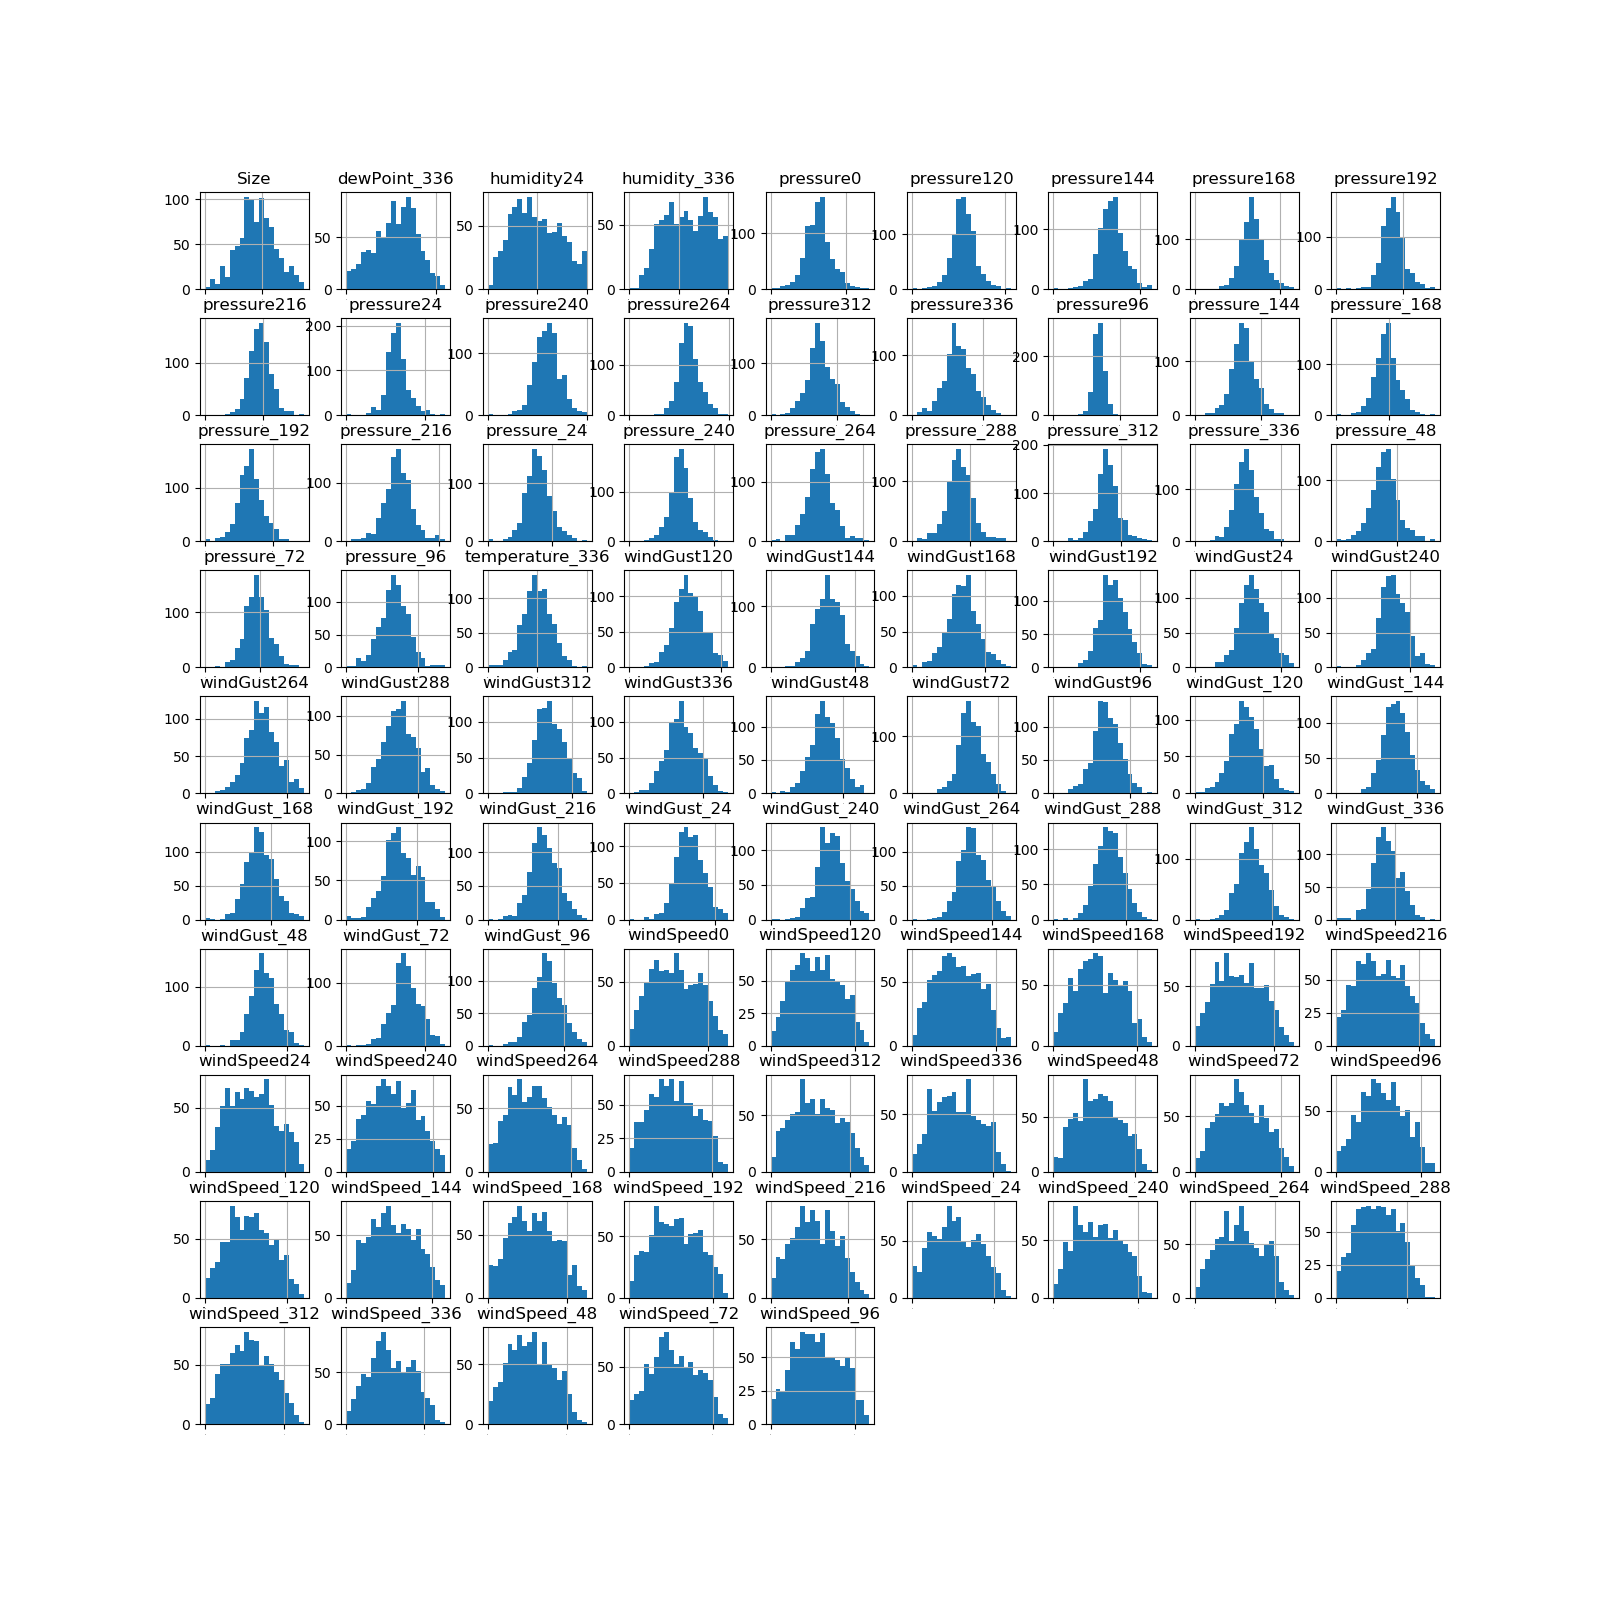

In [109]:
# now let's see the effect of normalization by generating those distribution plots again
ndf_hist = ndf.hist(bins=20, figsize=(16, 16), xlabelsize=1)

<IPython.core.display.Javascript object>


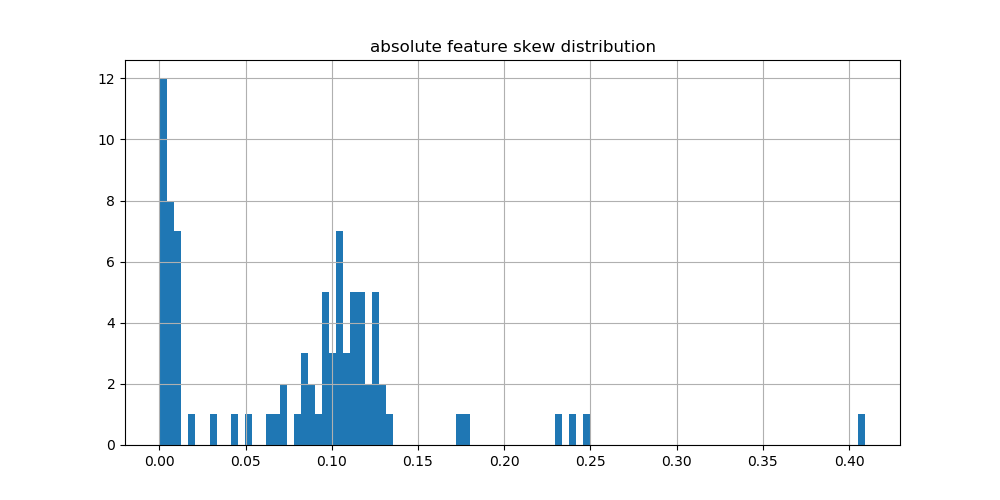

,skew
feature,
pressure96,0.409115
pressure24,0.248389
humidity24,0.238187
dewPoint_336,0.231895
pressure192,0.178228
pressure264,0.173217
windSpeed0,0.131339
pressure_312,0.129554
windSpeed216,0.128722


In [110]:
# Looks like we fixed the skew for some features, let's see their distribution (want cluster close to 0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("absolute feature skew distribution")
norm_skew_df = pd.DataFrame(ndf.skew())
norm_skew_df.index.name="feature"
norm_skew_df.columns=["skew"]
norm_skew_df["skew"] = norm_skew_df["skew"].map(abs)
norm_skew_hist = norm_skew_df["skew"].hist(bins=100, figsize=(10, 5), xlabelsize=10)
norm_skew_df = norm_skew_df.sort_values("skew",ascending=False)
norm_skew_df

In [111]:
# now let's rank each feature type by its mean absolute skew
norm_skew_df.index = norm_skew_df.index.map(indexed_feature_to_feature)
norm_skew_df = norm_skew_df.groupby("feature", sort=False)[["skew"]].mean().sort_values("skew",ascending=False)
norm_skew_df

,skew
feature,
dewPoint,0.231895
humidity,0.144651
pressure,0.115695
windSpeed,0.111114
temperature,0.098523
Size,0.009035
windGust,0.005674


In [112]:
# Create data splits using outlier reduced, feature-filtered, normalized dataframe
X_train,y_train,X_valid,y_valid,X_test,y_test, y_all = get_split(ndf, ndf.columns.to_list())

# Create new run (indexed by current date and time)
RUN_NAME = 'run_'+datetime.now().strftime("%Y%m%d_%H%M%S")

# data folder
outdir = './data/'+RUN_NAME

if not os.path.exists(outdir):
    os.mkdir(outdir)

def output(data, filename):
    data.to_csv(outdir+"/"+filename, header="False")
    
output(all_df, "all_data.csv")
output(ndf, "ndf.csv")

# export data splits to csv
output(X_train, "X_train.csv")
output(y_train, "y_train.csv")
output(X_valid, "X_valid.csv")
output(y_valid, "y_valid.csv")
output(X_test, "X_test.csv")
output(y_test, "y_test.csv")
output(y_all, "y_all.csv")

# create metrics file
with open(outdir+"/metrics_"+RUN_NAME+".txt", "w") as text_file:
    # summarize distribution of target feature for each data split
    text_file.write("Training targets summary:\n")
    text_file.write(y_train.describe().to_string()+'\n\n')
    text_file.write("Validation targets summary:\n")
    text_file.write(y_valid.describe().to_string()+'\n\n')
    text_file.write("Test targets summary:\n")
    text_file.write(y_test.describe().to_string()+'\n\n')
    text_file.write("All fire targets summary:\n")
    text_file.write(y_all.describe().to_string()+'\n\n')

# Linear Models

<IPython.core.display.Javascript object>


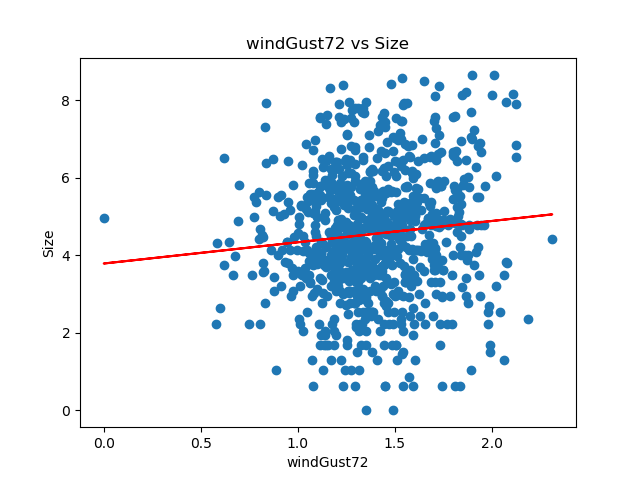

Size = 0.54904395 * windGust72 + 3.7833323
r^2 =  0.009435072651126974
mae:  1.2814109
rmse:  1.6105437247953063


<IPython.core.display.Javascript object>


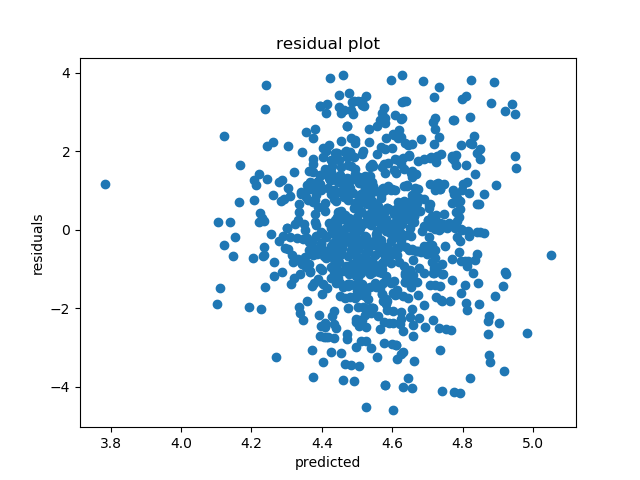

In [114]:
# 2D linear regression

# get most correlated descriptive feature
feature = abs_corr_specific_list[0]
target = "Size"

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel(target)
ax1.set_xlabel(feature)
ax1.set_title(feature+" vs "+target)

# create the regression model on the original dataframe
# X = all_df[feature].values.reshape(-1, 1)
# Y = all_df[target].values.reshape(-1, 1)

# create the regression model on the outlier reduced dataframe
X = ndf[feature].values.reshape(-1, 1)
Y = ndf[target].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

# extract the model parameters
coeff = lr.coef_
intercept = lr.intercept_
equation = target+" = "+str(coeff[0][0])+" * "+feature+" + "+str(intercept[0])
print(equation)
r_sq = lr.score(X, Y)
print("r^2 = ",r_sq)

mae = metrics.mean_absolute_error(Y, Y_pred)
rmse = math.sqrt(metrics.mean_squared_error(Y, Y_pred))
residuals = Y-Y_pred

results = pd.DataFrame({"actual": Y.flatten(), "predicted": Y_pred.flatten(), "residuals": residuals.flatten()})
print("mae: ", mae)
print("rmse: ", rmse)

# 2D scatter plot comparing two variables
img = plt.scatter(X, Y)
ax1.plot(X, Y_pred, color="red")
plt.show()

# create residual plot to check for heteroscedasticity
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("predicted")
ax.set_ylabel("residuals")
ax.set_title("residual plot")

img = plt.scatter(results["predicted"], results["residuals"])
plt.show()

using features: 
 ['windGust72', 'humidity24', 'windGust24', 'windGust48', 'pressure336', 'pressure264', 'pressure96', 'pressure24', 'pressure192', 'windSpeed24', 'pressure240', 'pressure_96', 'pressure_72', 'pressure216', 'pressure168', 'windSpeed72', 'pressure_312', 'pressure120', 'windGust144', 'pressure_48', 'pressure_144', 'temperature_336', 'pressure_168', 'pressure_192', 'pressure_288', 'windSpeed_144', 'pressure312', 'pressure0', 'pressure144', 'windSpeed288', 'windGust312', 'pressure_240', 'pressure_336', 'windSpeed216', 'windGust96', 'windGust168', 'dewPoint_336', 'windGust_72', 'windSpeed_240', 'windSpeed48', 'windSpeed_288', 'pressure_264', 'windSpeed_192', 'pressure_24', 'windSpeed_120', 'windSpeed240', 'windSpeed_96', 'windSpeed_216', 'windSpeed_264', 'windSpeed264', 'windGust240', 'windSpeed192', 'windSpeed144', 'windGust_216', 'windSpeed_24', 'windGust_48', 'windSpeed_312', 'pressure_216', 'windSpeed_48', 'windSpeed_168', 'windSpeed312', 'windGust288', 'windGust_264', '

<IPython.core.display.Javascript object>


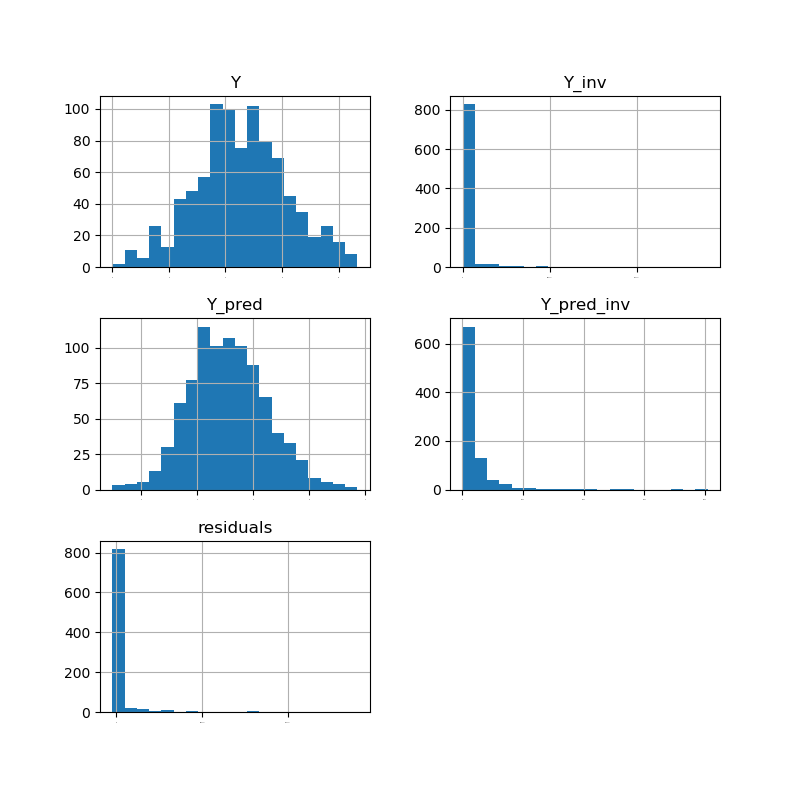

<IPython.core.display.Javascript object>


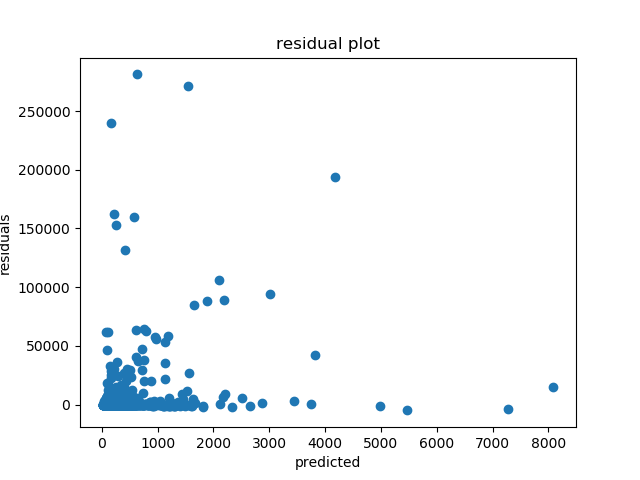

<IPython.core.display.Javascript object>


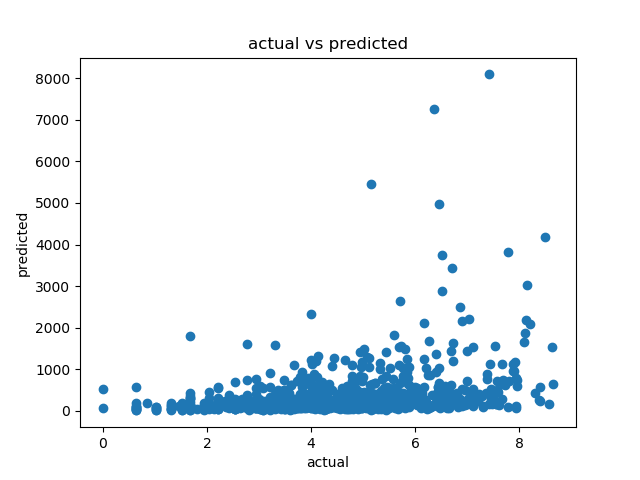

,Y,Y_pred,Y_inv,Y_pred_inv,residuals
0,6.295920,5.502198,3081.998926,866.491602,2215.507324
1,6.047731,5.207273,2050.000635,554.169702,1495.830933
2,1.818007,3.443044,6.000001,47.721281,-41.721280
3,3.551633,4.018229,55.000009,102.379022,-47.379013
4,3.642725,4.067051,62.000009,109.384920,-47.384911
5,7.430736,4.343588,23024.996484,159.885263,22865.111221
6,3.617844,4.103036,59.999994,114.871614,-54.871620
7,5.150246,3.148158,508.999933,32.592863,476.407070
8,4.170759,4.855817,125.999994,330.428400,-204.428406
9,4.257797,4.163409,141.999979,124.738901,17.261078


In [115]:
# High dimensional linear regression (using all absolutely correlated descriptive features)
target = "Size" # predict size

# use the top absolutely correlated features as inputs
features = abs_corr_specific_list
print("using features: \n", abs_corr_specific_list)
print("\n")
# create the regression model on the outlier reduced dataframe
X = ndf[features]
Y = ndf[target].values.reshape(-1, 1)
# X = X_train[features]
# Y = y_all.values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

# set all negative fire predictions to zero
# m = lambda x: [max(x[0], 0)] # TODO: Use clip function
# Y_pred = np.array([m(y) for y in Y_pred])

# extract the model parameters, note rounded values!
coefficients = lr.coef_.round(decimals=2)
intercept = lr.intercept_.round(decimals=2)

# construct the equation from model parameters
equation = target+" = "
for i in range(len(coefficients[0])):
    coeff = coefficients[0][i]
    f = features[i]
    equation+=str(coeff)+"*"+f+" + "
else:
    equation+=str(intercept[0])

print(equation, "\n")

r_sq = lr.score(X, Y)
print("r^2 = ",r_sq)

Y_inv = inv_box_cox_transform(Y, **params["Size"])
Y_pred_inv = inv_box_cox_transform(Y_pred, **params["Size"])

# mae = metrics.mean_absolute_error(Y, Y_pred)
# rmse = math.sqrt(metrics.mean_squared_error(Y, Y_pred))
# residuals = Y-Y_pred

mae = metrics.mean_absolute_error(Y_inv, Y_pred_inv)
rmse = math.sqrt(metrics.mean_squared_error(Y_inv, Y_pred_inv))
residuals = Y_inv-Y_pred_inv
print("mae: ", mae)
print("rmse: ", rmse)

results = pd.DataFrame({"Y": Y.flatten(), "Y_pred": Y_pred.flatten(), 
                        "Y_inv": Y_inv, "Y_pred_inv": Y_pred_inv, 
                        "residuals": residuals})

results.hist(bins=20, figsize=(8, 8), xlabelsize=1)

# create residual plot to check for heteroscedasticity
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("predicted")
ax.set_ylabel("residuals")
ax.set_title("residual plot")

img = plt.scatter(results["Y_pred_inv"], results["residuals"])

# plot actual vs predicted
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("actual")
ax.set_ylabel("predicted")
ax.set_title("actual vs predicted")

img = plt.scatter(results["Y"], results["Y_pred_inv"])
results # note: 1 acre ~ 0.75 football field

<IPython.core.display.Javascript object>


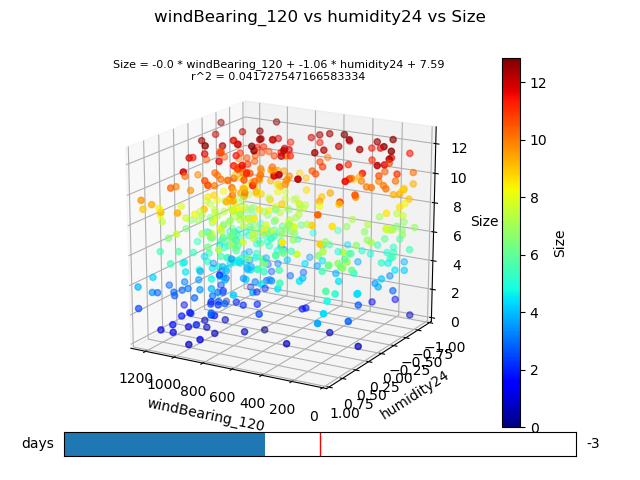

In [524]:
# Visualize a 3D scatter plot for multiple features over time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# descriptive features
f1 = abs_corr_specific_list[1]
f2 = abs_corr_specific_list[0]
f3 = "Size"
# target feature
f4 = "Size"

# select the dataframe to visualize
plot_df = ndf

# get feature bounds
f1_min, f1_max = get_feature_bounds(plot_df, f1)
f2_min, f2_max = get_feature_bounds(plot_df, f2)
f3_min, f3_max = get_feature_bounds(plot_df, f3)

def draw_scatter(i, ax, df):
    factor = 24
    index = i*factor
    f = lambda i, x: "" if x in ["Costs", "Latitude", "Longitude"] else (str(i) if i >= 0 else "_"+str(abs(i)))

    # set the hour offset per feature
#     x1=f1+f(index, f1)
#     x2=f2+f(index, f2)
#     x3=f3+f(index, f3)
#     x4=f4

    x1=f1
    x2=f2
    x3=f3
    x4=f4

    # set the axis values per feature
    x = df[x1]
    y = df[x2]
    z = df[x3]
    c = df[x4]

    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    ax.set_zlabel(x3)

    # set constant axis bounds
    ax.set_xlim(f1_min, f1_max)
    ax.set_ylim(f2_min, f2_max)
    ax.set_zlim(f3_min, f3_max)

    linear_features = [x1,x2]
    linear_target = x3
    
    # create the linear regression model
    X = df[linear_features] # use first two features as predictors to third
    Y = df[linear_target].values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    # extract the model parameters, note rounded values!
    coefficients = lr.coef_.round(decimals=2)
    intercept = lr.intercept_.round(decimals=2)

    # construct the equation from model parameters
    equation = linear_target+" = "
    for i in range(len(coefficients[0])):
        coeff = coefficients[0][i]
        f = linear_features[i]
        equation+=str(coeff)+" * "+f+" + "
    else:
        equation+=str(intercept[0])

    # ax.plot(x, y, Y_pred.flatten())

    # construct the line of best fit (needs fix)
#     lx = np.arange(f1_min, f1_max, 0.715)
#     ly = np.arange(f2_min, f2_max, 0.25)
#     inter = np.full((1, len(lx)), intercept[0])
#     lz = lx*coefficients[0][0] + ly*coefficients[0][1] + inter[0]
    
#     ax.plot(lx, ly, lz)
    
    r_sq = lr.score(X, Y)
    r_sq_str = "r^2 = "+str(r_sq)
                                     
    img = ax.scatter(x, y, z, c=c, cmap="jet")
    
    ax.set_title(label=equation+"\n"+r_sq_str, fontsize=8)
    fig.suptitle(x1+" vs "+x2+" vs "+x3)
    return img



init_slider_val = 0

# Update the axis for the initial scatterplot
img = draw_scatter(init_slider_val, ax, plot_df)

# Draw the colorbar and label it with the target feature
fig.colorbar(img).set_label(f4)

# Create a new slider axes with specified dimensions
slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])

# Create the slider
a_slider = Slider(slider_ax,      # the axes object containing the slider
                  'days',         # the name of the slider parameter
                  -14,            # minimal value of the parameter
                  14,             # maximal value of the parameter
                  valinit=0.,     # initial value of the parameter
                  valfmt="%i"
                 )

# Create integer slider offsets
def set_slider(s,val):
    s.val = int(round(val))
    s.poly.xy[2] = s.val,1
    s.poly.xy[3] = s.val,0
    s.valtext.set_text(s.valfmt % s.val)

# function to be executed each time slider
# value changes, variable of this function will
# be assigned the value of the slider
def update(a):
    # update the slider
    set_slider(a_slider, a)
    # get the the updated slider value
    a = int(a_slider.val)
    # clear the axis
    ax.clear()
    # update the axis
    draw_scatter(a, ax, plot_df)
    # redraw the plot
    fig.canvas.draw_idle()

# execute update on slider change
a_slider.on_changed(update)

plt.show()

In [126]:
# TODO: Use high dimensional regression equation on train/valid/test split (via cdf) and check RMSE values
# - Then try polynomial terms in high dimensional linear regression to maximize r^2

# - Then try to fit nonlinear functions like x^2 with mlp
# - Then see if you can generalize

In [277]:
# Load data splits from previous run

# norm_X_train = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_train.csv', index_col=0).astype("float32")
# norm_y_train = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_train.csv', index_col=0).astype("float32")


# norm_X_valid = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_valid.csv', index_col=0).astype("float32")
# norm_y_valid = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_valid.csv', index_col=0).astype("float32")

# norm_X_test = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_test.csv', index_col=0).astype("float32")
# norm_y_test = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_test.csv', index_col=0).astype("float32")

# print(norm_X_train.describe())
# print(norm_X_valid.describe())
# print(norm_X_test.describe())



In [340]:
# # normalize the descriptive and target features across each data split
# norm_X_train = normalize(X_train)
# norm_X_valid = normalize(X_valid)
# norm_X_test = normalize(X_test)
# norm_y_train = normalize(y_train)
# norm_y_valid = normalize(y_valid)
# norm_y_test = normalize(y_test)

# # export normalized data splits to csv
# norm_X_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_train.csv')
# norm_y_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_train.csv')
# norm_X_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_valid.csv')
# norm_y_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_valid.csv')
# norm_X_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_test.csv')
# norm_y_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_test.csv')

# # plot distribution of normalized target feature for each data split
# norm_y_train_hist = norm_y_train.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_train_hist.png')
# norm_y_valid_hist = norm_y_valid.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_valid_hist.png')
# norm_y_test_hist = norm_y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
# plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_test_hist.png')

# # summarize distribution of normalized descriptive features for each data split
# print("Training descriptive features summary:")
# print(norm_X_train.describe())
# print("Validation descriptive features summary:")
# print(norm_X_valid.describe())
# print("Test descriptive features summary:")
# print(norm_X_test.describe())

# # summarize distribution of normalized target feature for each data split
# print("Training targets summary:")
# print(y_train.describe())
# print("Validation targets summary:")
# print(y_valid.describe())
# print("Test targets summary:")
# print(y_test.describe())
# print("All fire targets summary:")
# print(y_all.describe())


# Neural Network Models

In [341]:
# define the tf input functions for training
def training_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_train, 
                                      norm_y_train["Size"], 
                                      batch_size=batch_size)

def validation_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_valid, 
                                            norm_y_valid["Size"], 
                                            num_epochs=1, 
                                            shuffle=False)

In [66]:
# get tf descriptive features
feature_columns = construct_feature_columns(norm_X_train)

# set learning parameters
STEPS_PER_EPOCH = 100
EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 0.001

# set network architecture
neuron_split = 2**0
num_neurons = math.floor(len(norm_X_train.columns)/neuron_split)
num_layers = 1
hidden_layers = []

# add hidden layers to network
for i in range(num_layers):
    hidden_layers.append(num_neurons)
print(hidden_layers)

# set dropout probability
dropout = 0.5


MODEL_PATH='./models/DNNRegressors/'+RUN_NAME+'/'

run_str = ""
for hl in hidden_layers:
	run_str += '%s_' % hl
run_str += 'D0%s' % (int(dropout*10))
MODEL_PATH += run_str
logging.info('Saving to %s' % MODEL_PATH)

# validation and test configuration
validation_metrics = {"RMSE": tf.contrib.metrics.streaming_root_mean_squared_error}
test_config = skflow.RunConfig(save_checkpoints_steps=100, save_checkpoints_secs=None)

# create the optimizer
my_optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# build the network
regressor = skflow.DNNRegressor(feature_columns=feature_columns,
# regressor = estimator.DNNRegressor(feature_columns=feature_columns,
				label_dimension=1,
                optimizer=my_optimizer,
				hidden_units=hidden_layers,
				model_dir=MODEL_PATH,
				dropout=dropout,
				config=test_config)


INFO:root:Saving to ./models/DNNRegressors/run_8/87_D05


1
[87]


In [67]:
TRAINING = True
WITHPLOT = False

# Train it
if TRAINING:
	logging.info('Train the DNN Regressor...\n')
	MSEs = []	# for plotting
	STEPS = []	# for plotting

	for epoch in range(EPOCHS+1):

		# Fit the DNNRegressor (This is where the magic happens!!!)
		regressor.fit(input_fn=training_input_fn(batch_size=BATCH_SIZE),
				steps=STEPS_PER_EPOCH)
		# Thats it -----------------------------
		# Start Tensorboard in Terminal:
		# 	tensorboard --logdir='./models/DNNRegressors/'
		# Now open Browser and visit localhost:6006\

		
		# This is just for fun and educational purpose:
		# Evaluate the DNNRegressor every 10th epoch
		if epoch%10==0:
			eval_dict = regressor.evaluate(input_fn=validation_input_fn(),
							metrics=validation_metrics)
# 			print(eval_dict)
			print('Epoch %i: %.5f RMSE' % (epoch+1, eval_dict['RMSE']))


			if WITHPLOT:
				# Generate a plot for this epoch to see the network learning
				y_pred = regressor.predict(x={'X': X}, as_iterable=False)

				E = (y.reshape((1,-1))-y_pred)
				MSE = np.mean(E**2.0)
				step = (epoch+1) * STEPS_PER_EPOCH
				title_string = '%s DNNRegressor after %06d steps (MSE=%.5f)' % \
								(MODEL_PATH.split('/')[-1], step, MSE)
				
				MSEs.append(MSE)
				STEPS.append(step)

				fig = plt.figure(figsize=(9,4))
				ax1 = fig.add_subplot(1, 4, (1, 3))
				ax1.plot(X, y, label='function to predict')
				ax1.plot(X, y_pred, label='DNNRegressor prediction')
				ax1.legend(loc=2)
				ax1.set_title(title_string)
				ax1.set_ylim([0, 1])

				ax2 = fig.add_subplot(1, 4, 4)
				ax2.plot(STEPS, MSEs)
				ax2.set_xlabel('Step')
				ax2.set_xlim([0, EPOCHS*STEPS_PER_EPOCH])
				ax2.set_ylabel('Mean Square Error')
				ax2.set_ylim([0, 0.01])

				plt.tight_layout()
				plt.savefig(MODEL_PATH + '_%05d.png' % (epoch+1), dpi=72)
				logging.info('Saved %s' % MODEL_PATH + '_%05d.png' % (epoch+1))

				plt.close()

    # Now it's trained. We can try to predict some values.
else:
    logging.info('No training today, just prediction')
    try:
        # final Plot
        if WITHPLOT:
            plt.plot(X, y, label='function to predict')
            plt.plot(X, regressor.predict(x={'X': X}, as_iterable=False), \
                     label='DNNRegressor prediction')
            plt.legend(loc=2)
            plt.ylim([0, 1])
            plt.title('%s DNNRegressor' % MODEL_PATH.split('/')[-1])
            plt.tight_layout()
            plt.savefig(MODEL_PATH + '.png', dpi=72)
            plt.close()
    except:
        logging.Error('Prediction failed! Maybe first train a model?')

INFO:root:Train the DNN Regressor...



Epoch 1: 2.52311 RMSE
Epoch 11: 2.46751 RMSE
Epoch 21: 2.47693 RMSE
Epoch 31: 2.47769 RMSE
Epoch 41: 2.51087 RMSE
Epoch 51: 2.48353 RMSE
Epoch 61: 2.49004 RMSE
Epoch 71: 2.49172 RMSE
Epoch 81: 2.48900 RMSE
Epoch 91: 2.49584 RMSE
Epoch 101: 2.51023 RMSE


In [68]:
# get trained values out of the network
for variable_name in regressor.get_variable_names():
    if str(variable_name).startswith('dnn/hiddenlayer') and \
    (str(variable_name).endswith('weights') or \
         str(variable_name).endswith('biases')):
        print('\n%s:' % variable_name)
        weights = regressor.get_variable_value(variable_name)
        print(weights)
        print('size: %i' % weights.size)


dnn/hiddenlayer_0/biases:
[ 2.47e-02 -1.64e-02  8.13e-03 -1.82e-02 -1.67e-02 -3.44e-02 -2.06e-03
 -1.55e-02  4.90e-03  4.71e-03  0.00e+00 -5.19e-03  0.00e+00 -8.80e-03
 -2.10e-02 -6.01e-03 -1.91e-02  0.00e+00 -1.16e-02 -1.43e-02  0.00e+00
 -6.87e-03 -5.05e-03 -7.84e-03  0.00e+00 -2.48e-02  0.00e+00  0.00e+00
 -9.10e-03 -2.54e-02 -5.59e-03  0.00e+00  0.00e+00  1.85e-02  5.55e-03
 -3.30e-02 -2.72e-02  1.61e-02  0.00e+00  0.00e+00  0.00e+00 -2.08e-02
  0.00e+00 -2.87e-03  0.00e+00 -3.49e-02 -2.55e-02 -2.33e-02 -6.61e-02
 -1.41e-02 -2.20e-02  0.00e+00 -5.13e-03 -9.11e-03 -1.20e-02  0.00e+00
 -6.31e-03  3.30e-03  0.00e+00  6.79e-03  0.00e+00 -7.53e-03 -8.54e-03
  9.88e-05 -1.94e-02 -2.33e-02  6.27e-03 -3.09e-03 -2.18e-02  2.87e-03
  0.00e+00 -8.58e-03 -5.56e-03  0.00e+00 -9.37e-03  9.51e-04  0.00e+00
  0.00e+00  0.00e+00 -3.39e-02 -2.64e-03 -5.66e-03 -1.50e-02 -1.05e-02
 -2.82e-02  3.04e-02  0.00e+00]
size: 87

dnn/hiddenlayer_0/weights:
[[-0.45 -0.13 -0.13 ...  0.16 -0.23  0.02]
 [-0.26 -

In [69]:
# create metrics file
with open(".\\data\\"+RUN_NAME+"\\metrics_"+run_str+".txt", "w") as text_file:
    unnormalized_predict_targets = y_test["Size"].reset_index(drop=True)
    normalized_predict_targets = norm_y_test["Size"].reset_index(drop=True)

    def predict_test_input_fn(batch_size=1):
        return lambda: my_input_fn(norm_X_test, 
                                                normalized_predict_targets, 
                                                num_epochs=1,
                                                batch_size=batch_size,
                                                shuffle=False)

    normalized_test_predictions = regressor.predict(input_fn=predict_test_input_fn(batch_size=len(normalized_predict_targets)+2), as_iterable=False)


    normalized_test_mae = metrics.mean_absolute_error(normalized_predict_targets, normalized_test_predictions)


    compare_df = pd.DataFrame()
    compare_df["unnormalized_test_predictions"] = pd.DataFrame(normalized_test_predictions)[0].apply(lambda x: math.exp(x)-1)
    compare_df["unnormalized_predict_targets"] = unnormalized_predict_targets
    compare_df["diff"] = compare_df["unnormalized_test_predictions"] - compare_df["unnormalized_predict_targets"]

    over_df = compare_df["diff"][lambda x: x >= 0]
    over = len(over_df.index)

    under_df = compare_df["diff"][lambda x: x < 0]
    under = len(under_df.index)

    print("predicted too high count:")
    text_file.write("predicted too high count:")
    text_file.write('\n')
    print(over)
    text_file.write(str(over))
    text_file.write('\n')
    print("predicted too high percent of total:")
    text_file.write("predicted too high percent of total:")
    text_file.write('\n')
    print(over/len(compare_df["diff"].index))
    text_file.write(str(over/len(compare_df["diff"].index)))
    text_file.write('\n')
    print("predicted too high mean bias error:")
    text_file.write("predicted too high mean bias error:")
    text_file.write('\n')
    print(over_df.mean())
    text_file.write(str(over_df.mean()))
    text_file.write('\n')

    print('\n')
    text_file.write('\n')

    print("predicted too low count:")
    text_file.write("predicted too low count:")
    text_file.write('\n')
    print(under)
    text_file.write(str(under))
    text_file.write('\n')
    print("predicted too low percent of total:")
    text_file.write("predicted too low percent of total:")
    text_file.write('\n')
    print(under/len(compare_df["diff"].index))
    text_file.write(str(under/len(compare_df["diff"].index)))
    text_file.write('\n')
    print("predicted too low mean bias error:")
    text_file.write("predicted too low mean bias error:")
    text_file.write('\n')
    print(under_df.mean())
    text_file.write(str(under_df.mean()))
    text_file.write('\n')

    print('\n')
    text_file.write('\n')

    print("total mean absolute error:")
    text_file.write("total mean absolute error:")
    text_file.write('\n')
    mae = compare_df["diff"].apply(lambda x: abs(x)).mean()
    print(mae)
    text_file.write(str(mae))
    text_file.write('\n')
    print("total mean bias error:")
    text_file.write("total mean bias error:")
    text_file.write('\n')
    mbe = compare_df["diff"].mean()
    print(mbe)
    text_file.write(str(mbe))
    text_file.write('\n')
    print("total mean squared error:")
    text_file.write("total mean squared error:")
    text_file.write('\n')
    mse = compare_df["diff"].apply(lambda x: x**2).mean()
    print(mse)
    text_file.write(str(mse))
    text_file.write('\n')
    rmse = math.sqrt(mse)
    print("total root mean squared error:")
    text_file.write("total root mean squared error:")
    text_file.write('\n')
    print(rmse)
    text_file.write(str(rmse))
    text_file.write('\n')

    print(compare_df)
    compare_df.to_csv('.\\data\\'+RUN_NAME+'\\compare_df_'+run_str+'.csv')


predicted too high count:
93
predicted too high percent of total:
0.5081967213114754
predicted too high mean bias error:
240.821998070441


predicted too low count:
90
predicted too low percent of total:
0.4918032786885246
predicted too low mean bias error:
-6085.158308448448


total mean absolute error:
3115.0857572727396
total mean bias error:
-2870.315857594586
total mean squared error:
159208831.31819496
total root mean squared error:
12617.798196127364
     unnormalized_test_predictions  unnormalized_predict_targets          diff
0                       314.634616                          40.0    274.634616
1                       268.294133                          53.0    215.294133
2                       460.502353                          26.0    434.502353
3                       277.365196                         700.0   -422.634804
4                       152.851427                        1080.0   -927.148573
5                       204.210761                       91281.0